# ДЗ 4. Диффузия
В этой домашке вам предстоит обучить DDPM на пресловутых лицах (CelebA 32х32). Решением является решенный ноутбук с обучением модели, сгенерированными картинками и, по требованию проверяющего, чекпоинтами

# Imports and Definitions

In [2]:
# import sys
# sys.path.append('C:\\Users\\platon2612\\Desktop\\hw2_generatives\\utils')

#!g1.1

from celeba import CelebADataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.auto import trange, tqdm
import os 
from torch import nn

from torch import Tensor

# Визуализация данных

In [3]:
def show_images(images, title=""):
    """Shows images in a grid"""
    # Ensure 4D tensor (B,C,H,W)
    if isinstance(images, torch.Tensor):
        if images.dim() == 3:
            images = images.unsqueeze(0)  # Add batch dimension
        images = images.detach().cpu().permute(0,2,3,1).numpy()

    fig = plt.figure(figsize=(8, 8))
    n = int(len(images)**0.5)
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.imshow((255*(images[i]+1)/2).astype('uint8'))
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

def show_first_batch(loader):
    for batch in loader:
        # If dataset returns (data, labels), use batch[0]
        # If dataset returns only data, use batch directly
        show_images(batch[0] if isinstance(batch, (list, tuple)) else batch)
        break

## Загрузка данных (0 баллов)

Мы будем использовать CelebA (32x32). **Важно**: отнормируйте данные в интервал `[-1,1]`.

In [4]:
# !cd /content/gdrive/MyDrive/celeba && unzip img_align_celeba.zip > /dev/null # распаковка

In [52]:
#!g1.1
t_normalize = lambda x: x * 2 - 1
t_invnormalize = lambda x: (x + 1) / 2
transform=transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    t_normalize,
])

#!g1.1

batch_size = 128

dataset = CelebADataset(
    root_dir = "sem/data/celeba",
    transform=transform
)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle = True)

from tqdm import tqdm
for img, _ in tqdm(dataloader):
    pass
img, _ = dataset[0]
img.shape


100%|██████████| 21/21 [00:01<00:00, 10.66it/s]


torch.Size([3, 32, 32])

In [6]:
show_first_batch(dataloader)

In [7]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cpu	CPU


# Denoising Diffusion Model (DDPM) (2 балла)

## Recap
Диффузия - это обратимый стохастический процесс, в котором картинка зашумляется по известному гауссовскому закону $q(x_t|x_{t-1})$ и денойзится по неизвестному обратному гауссовскому закону $p(x_{t-1}|x_t)$, который приближается нейросетью $p_\theta$
![](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png)

Известный закон $q$ (он же forward pass) описывается по формуле:
$$
\begin{aligned}
\mathbf{x}_t 
&= \sqrt{\alpha_t}\mathbf{x}_{t-1} + \sqrt{1 - \alpha_t}\boldsymbol{\epsilon}_{t-1} & \text{ ;where } \boldsymbol{\epsilon}_{t-1}, \boldsymbol{\epsilon}_{t-2}, \dots \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \\
&= \sqrt{\alpha_t \alpha_{t-1}} \mathbf{x}_{t-2} + \sqrt{1 - \alpha_t \alpha_{t-1}} \bar{\boldsymbol{\epsilon}}_{t-2} & \text{ ;where } \bar{\boldsymbol{\epsilon}}_{t-2} \text{ merges two Gaussians (*).} \\
&= \dots \\
&= \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon} \\
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}
$$, где $\alpha$ - заранее определенные по определенной сетке константы

Неизвестная же гауссиана обратного закона (он же backward pass) предсказывается нейросетью:
$p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1};\mu_\theta(x_t, t),\sigma_\theta(x_t,t))$ (т.е. предсказываются $\mu$ и $\sigma$, 1в1 как в вариационном енкодере)

Кроме этого, так же, как в варэнкодере, $p_\theta$ выучивается максимизацией ELBO (и даже KL там тоже между двумя гауссианами)

Ну а выучив обратный процесс денойзинга $p_\theta(x_{t-1}|x_t)$, дело останется за малым: берём $x_T\sim\mathcal{N}(0,1)$ и семплируем $x_{t-1}\sim p_\theta(x_{t-1}|x_t)$, пока не восстановим наш незашумленный $x_0$. Это и будет какая-то картинка

## DDPM

С варвыводом вы уже хорошо знакомы, но авторы DDPM решили с ним не париться и забить на $\sigma_t$, сделав её заранее определённой константой, например:
- $\sigma_t^2$ = $\beta_t$
- $\sigma_t^2$ = $\frac{1 - \bar{\alpha_{t-1}}}{1 - \bar{\alpha_{t}}} \beta_t$

Тогда
$$q(x_{t-1}|x_0, x_t)=\mathcal{N}(x_{t-1}|\mu_t^q,\sigma_t)$$
$$p_\theta(x_{t-1}|x_t)=\mathcal{N}(x_{t-1}|\mu_t^\theta,\sigma_t)$$

Кроме этого, из вышеуказанного прямого закона $q$ несложно представить $\mu_t^q$ в виде 

$$\boldsymbol{\mu}^q_t = \frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_t \Big)$$

Так давайте представим и $\mu^\theta_t$ в таком виде, раз так:
$$\boldsymbol{\mu}^\theta_t = \frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_t^\theta(x_t,t) \Big)$$ 

Тогда весь $KL(q|p_\theta)$ сведётся к минимизации MSE

$$||\mu_t^q-\mu_t^\theta||^2\sim||\epsilon_t-\epsilon_t^\theta(x_t,t)||^2$$

Ну а зашумленный $x_t$ можно считать из исходного $x_0$ по быстрой формуле (см. самое начало):

$$x_t=\sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}_t$$

$\epsilon_t$ же на деле берут случайно из $\mathcal{N}(0,1)$

Итого, все-эти-ваши диффузии можно представить в виде нескольких строк кода:
![](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM-algo.png)

Прим. В качестве $\epsilon^\theta$ берут любой Unet-like бэкбон (кроме этого, есть оптимизированный под диффузию Efficient Unet)

Для большей инфы по диффузии идите сюда https://lilianweng.github.io/posts/2021-07-11-diffusion-models/


In [53]:
# Реализация UNet с временными embedding
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat([embeddings.sin(), embeddings.cos()], dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm = nn.GroupNorm(8, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.act = nn.SiLU()

    def forward(self, x, t):
        h = self.conv1(x)
        h = self.norm(h)
        h = self.act(h)
        t = self.time_mlp(t)
        h = h + t[:, :, None, None]
        h = self.conv2(h)
        h = self.norm(h)
        h = self.act(h)
        return h
    
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, time_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim),
        )
        self.down1 = Block(in_channels, 64, time_dim)
        self.down2 = Block(64, 128, time_dim)
        self.bottleneck = Block(128, 256, time_dim)
        self.up1 = Block(256 + 128, 128, time_dim)
        self.up2 = Block(128 + 64, 64, time_dim)
        self.out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x, t):
        t = self.time_mlp(t)
        d1 = self.down1(x, t)
        d2 = self.down2(d1, t)
        b = self.bottleneck(d2, t)
        u1 = self.up1(torch.cat([b, d2], dim=1), t)
        u2 = self.up2(torch.cat([u1, d1], dim=1), t)
        return self.out(u2)

# DDPM class
class DDPM(nn.Module):
    def __init__(self, network, n_steps=1000, min_beta=0.0001, max_beta=0.02, device=None, image_chw=(3,32,32)):
        super().__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0).to(device)

    def forward(self, x0, t, eta=None):
        if eta is None:
            eta = torch.randn_like(x0).to(device)
        alpha_bars_t = self.alpha_bars[t].view(-1,1,1,1)
        noised_x = torch.sqrt(alpha_bars_t) * x0 + torch.sqrt(1 - alpha_bars_t) * eta
        return noised_x

    def backward(self, x, t):
        return self.network(x, t)

## Visualizing forward and backward (2 балла)

In [54]:
# Визуализация прямого процесса
def show_forward(ddpm, loader, device):
    for batch in loader:
        imgs = batch[0].to(device)
        show_images(imgs.cpu(), "Original images")
        for percent in [0.25, 0.5, 0.75, 1]:
            t = (torch.ones(imgs.shape[0]) * percent * (ddpm.n_steps - 1)).long().to(device)
            noised_images = ddpm.forward(imgs, t)
            show_images(noised_images.cpu(), f"Noisy {int(percent*100)}%")
        break

In [55]:
# Генерация изображений
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100,
                        gif_name="sampling.gif", c=3, h=32, w=32):
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []
    
    with torch.no_grad():
        x = torch.randn(n_samples, c, h, w).to(device)
        for idx, t in enumerate(range(ddpm.n_steps-1, -1, -1)):
            time_tensor = torch.tensor([t]*n_samples, device=device).long()
            eta_theta = ddpm.backward(x, time_tensor)
            
            alpha_t = ddpm.alphas[t]
            alpha_bar_t = ddpm.alpha_bars[t]
            
            x = (x - (1 - alpha_t)/torch.sqrt(1 - alpha_bar_t) * eta_theta) / torch.sqrt(alpha_t)
            
            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)
                beta_t = ddpm.betas[t]
                alpha_bar_prev = ddpm.alpha_bars[t-1]
                sigma_t = torch.sqrt((beta_t * (1 - alpha_bar_prev)/(1 - alpha_bar_t)))
                x = x + sigma_t * z
            
            if idx in frame_idxs or t == 0:
                normalized = (x + 1) * 127.5
                normalized = normalized.clamp(0, 255).type(torch.uint8)
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples**0.5))
                frames.append(frame.cpu().numpy())
    

# UNet backbone ($\epsilon^\theta$) (3 балла)

Как уже было сказано, в качестве $\epsilon^\theta$ подойдёт любой Unet-like бэкбон (который будет принимать на вход зашумлённую картинку и на выходе возвращать восстановленный шум $\epsilon_t$ той же размерности). Одна незадача - вторым аргументом $\epsilon^\theta$ принимает время (шаг зашумления) $t$, чего в ванильном Unet'e нет.

К счастью, есть миллион и один способ добавить время дополнительным аргументом (например, AdaIN, как в StyleGAN, дополнительным каналом и т.д.)

На практике же в DDPM делают positional encoding (тот самый, который в Трансформере) времени $t$ и дальше просто плюсуют его прямо к входной картинке $x$. Мало того, вместе в временем иногда ещё и какие-нибудь текстовые эмбединги приплюсовывают (сжимая их нехитрым образом до нужной размерности через дополнительный линейный слой)

С текстовыми эмбедингами мы работать в этой домашке не будем, а вот $t$ добавлять будем ровно последним способом 

In [73]:
def sinusoidal_embedding(num_embeddings: int, embedding_dim: int) -> torch.Tensor:
    """Generates sinusoidal positional embeddings for diffusion time steps."""
    half_dim = embedding_dim // 2
    embeddings = torch.zeros(num_embeddings, embedding_dim)
    
    # Calculate wavelength progression
    wavelengths = 1 / (10_000 ** (torch.arange(half_dim) / half_dim))
    positions = torch.arange(num_embeddings).unsqueeze(1)
    
    # Generate sine and cosine embeddings
    embeddings[:, :half_dim] = torch.sin(positions * wavelengths)
    embeddings[:, half_dim:] = torch.cos(positions * wavelengths)
    
    return embeddings

class DiffusionUNet(nn.Module):
    """UNet architecture with time-step conditioning for diffusion models."""
    
    def __init__(self, num_timesteps: int = 1000, time_embed_dim: int = 100):
        super().__init__()
        
        # Time embedding layer (corrected name)
        self.time_embed = nn.Embedding(num_timesteps, time_embed_dim)
        self.time_embed.weight.data = sinusoidal_embedding(num_timesteps, time_embed_dim)
        self.time_embed.requires_grad_(False)

        # Encoder with proper input channels (critical fix)
        self.encoder = nn.ModuleDict(dict(
            conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1),
            conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        ))

        # Time projections with matching dimensions
        self.time_proj = nn.ModuleDict(dict(
            conv1 = self._build_time_proj(time_embed_dim, 64),
            conv2 = self._build_time_proj(time_embed_dim, 128),
            conv3 = self._build_time_proj(time_embed_dim, 256)
        ))

        # Rest of the network remains the same...

    def _build_time_proj(self, in_dim: int, out_dim: int) -> nn.Module:
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.SiLU(),
            nn.Linear(out_dim, out_dim)
        )

    def forward(self, x: torch.Tensor, timesteps: torch.Tensor) -> torch.Tensor:
        """Forward pass with time-step conditioning."""
        batch_size = x.shape[0]
        time_emb = self.time_embedding(timesteps)

        # Encoder path with time conditioning
        x1 = F.silu(self.encoder_conv1(x) + self.time_proj_conv1(time_emb).view(batch_size, -1, 1, 1))
        x2 = F.silu(self.encoder_conv2(x1) + self.time_proj_conv2(time_emb).view(batch_size, -1, 1, 1))
        x3 = F.silu(self.encoder_conv3(x2) + self.time_proj_conv3(time_emb).view(batch_size, -1, 1, 1))

        # Middle block processing
        mid = F.silu(self.mid_conv1(x3) + self.time_proj_mid1(time_emb).view(batch_size, -1, 1, 1))
        mid = F.silu(self.mid_conv2(mid) + self.time_proj_mid2(time_emb).view(batch_size, -1, 1, 1))

        # Decoder path with skip connections
        up1 = F.silu(self.decoder_upconv1(torch.cat([mid, x3], dim=1)) + 
                    self.time_proj_up1(time_emb).view(batch_size, -1, 1, 1))
        up2 = F.silu(self.decoder_upconv2(torch.cat([up1, x2], dim=1)) + 
                    self.time_proj_up2(time_emb).view(batch_size, -1, 1, 1))
        
        return self.final_conv(torch.cat([up2, x1], dim=1))

In [74]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ddpm = DDPM(UNet(n_steps), 
           n_steps=n_steps,
           min_beta=min_beta,
           max_beta=max_beta,
           device=device).to(device)

In [ ]:
sum([p.numel() for p in ddpm.parameters()])

650430

# Optional visualizations

In [ ]:
# Optionally, load a pre-trained model that will be further trained
# ddpm.load_state_dict(torch.load(store_path, map_location=device))

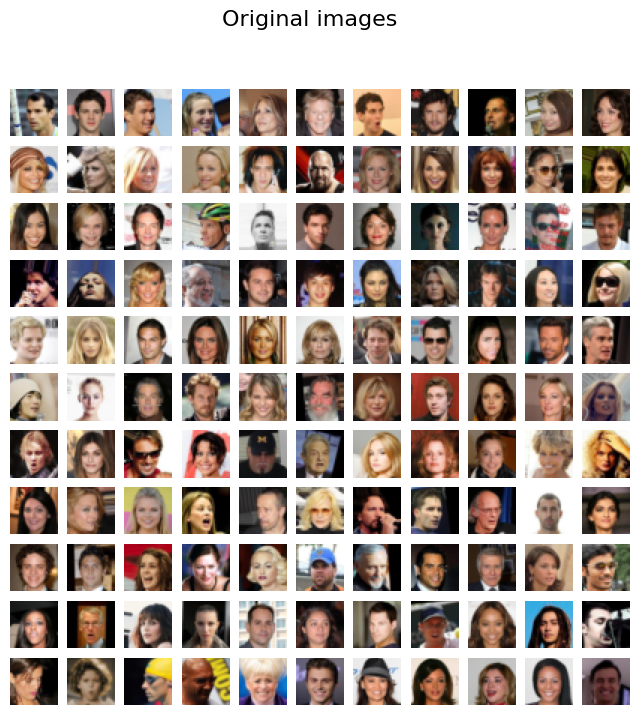

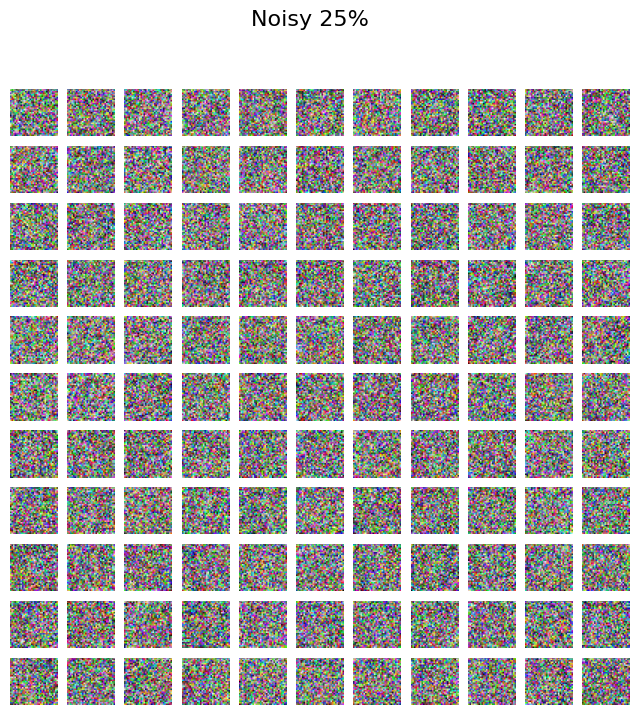

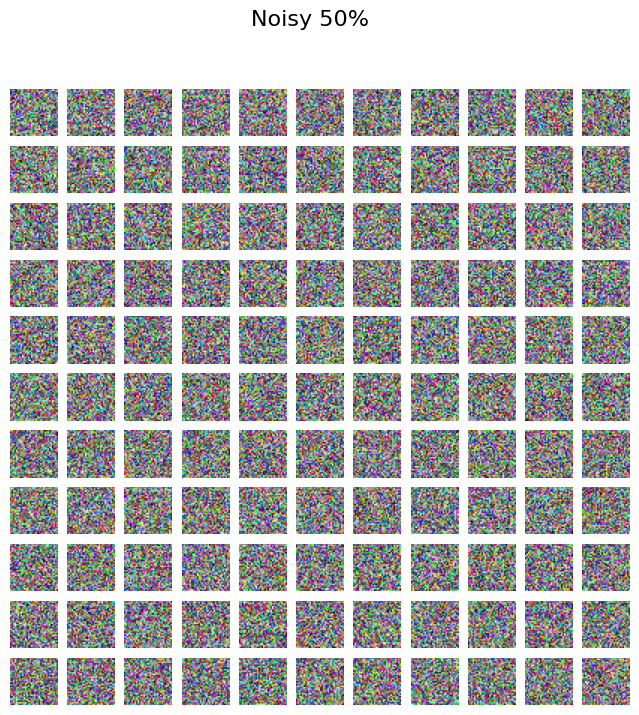

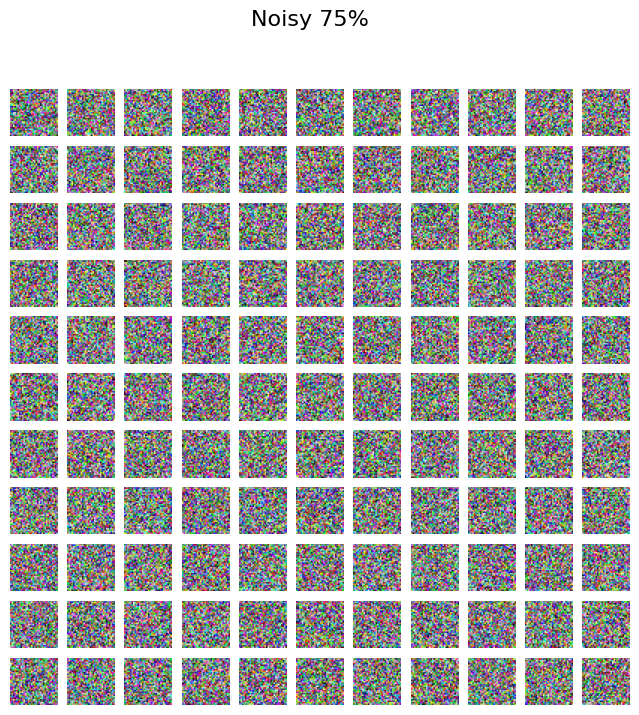

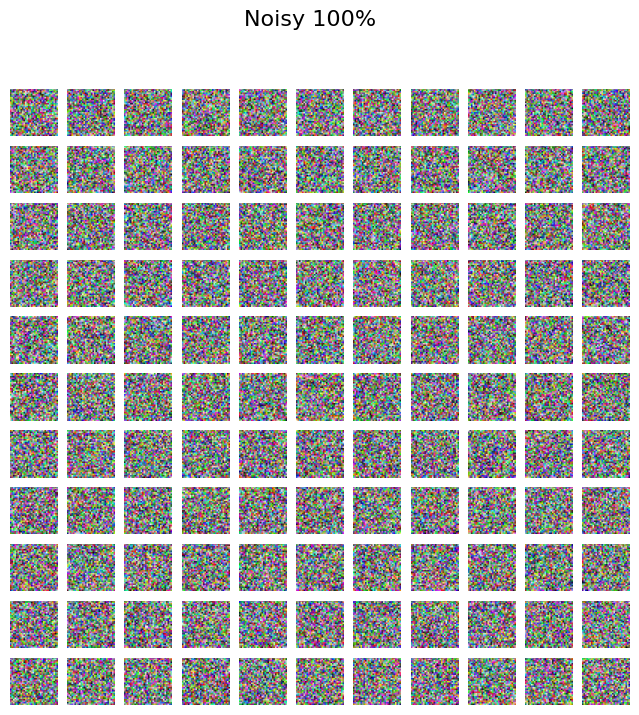

In [69]:
# Optionally, show the diffusion (forward) process
show_forward(ddpm, dataloader, device)

# Обучение (1 балл)
![](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM-algo.png)

In [75]:
def training_loop(ddpm, dataloader, n_epochs, optim, device, display=False, store_path="celeba_ddpm.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    try:
        ddpm.load_state_dict(torch.load(store_path))
        print("Loaded pre-trained weights.")
        return
    except FileNotFoundError:
        print("No pre-trained weights found. Initializing models from scratch.")

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(dataloader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            x0 = batch[0].to(device)


            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (x0.size(0),)).to(device)

            noisy_imgs = ddpm.forward(x0, t, eta)

            eta_theta = ddpm.backward(noisy_imgs, t)

            loss = mse(eta_theta, eta)

            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(dataloader.dataset)

        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")
        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

In [76]:
store_path = "check_points/celeba_ddpm.pt"

In [78]:
# Training
from torch.optim import Adam

#params
n_epochs = 10
lr = 1e-3

if not os.path.isdir(os.path.dirname(store_path)):
    os.makedirs(os.path.dirname(store_path), exist_ok=True)
training_loop(ddpm, dataloader, n_epochs, optim=Adam(ddpm.parameters(), lr), device=device, store_path=store_path)

No pre-trained weights found. Initializing models from scratch.


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 1000, 3, 3], expected input[128, 3, 32, 32] to have 1000 channels, but got 3 channels instead

# Генерёжка (2 балла за хорошие картинки)

In [ ]:
# Loading the trained model
best_model = DDPM(UNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


In [ ]:
print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=100,
        device=device,
        gif_name="celeba.gif"
    )
show_images(generated, "Final result")

# Visualizing the diffusion

In [ ]:
from IPython.display import Image

Image(open('celeba.gif','rb').read())